In [ ]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

DB_PATH = "../data/database.db"

# Step 1: Load and expand genres from SQLite
def load_movies_with_genres(db_path):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql("SELECT * FROM movies", conn)
    conn.close()
    
    # Parse JSON string into lists
    df['genres'] = df['genres'].apply(json.loads)

    # Explode genres into separate rows for analysis
    df_exploded = df.explode('genres')
    
    return df, df_exploded

df, df_exploded = load_movies_with_genres(DB_PATH)



In [ ]:
# Step 2: Top 10 most frequent genres
genre_counts = df_exploded['genres'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title("Top 10 Most Frequent Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()



In [ ]:

# Step 3: Average rating per genre
genre_avg_rating = df_exploded.groupby('genres')['vote_average'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_avg_rating.values, y=genre_avg_rating.index, palette='magma')
plt.title("Top 10 Genres by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()



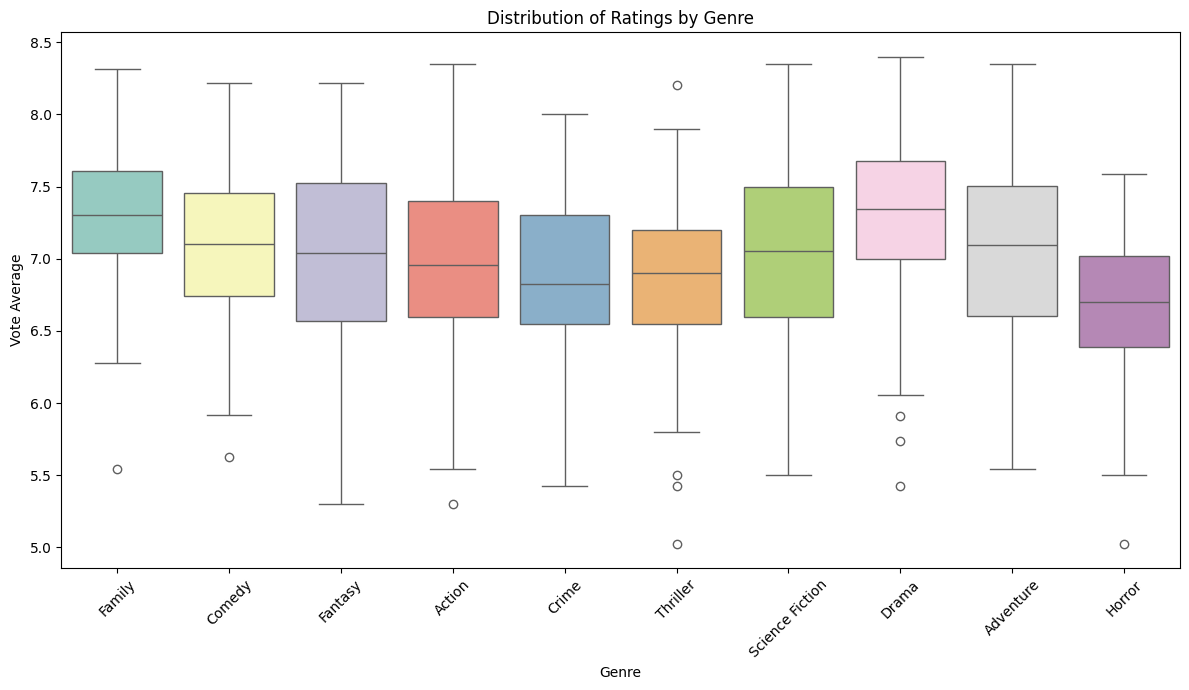

In [6]:
# Step 4: Box plot of vote_average by top genres
top_genres = genre_counts.index.tolist()
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
            x='genres', y='vote_average', palette='Set3')
plt.title("Distribution of Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Vote Average")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#  5: Box plot of vote_count by genre (log scale)
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
            x='genres', y='vote_count', palette='Set2')
plt.yscale('log')  # vote_count often has long tail
plt.title("Distribution of Vote Count by Genre (Log Scale)")
plt.xlabel("Genre")
plt.ylabel("Vote Count (log)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


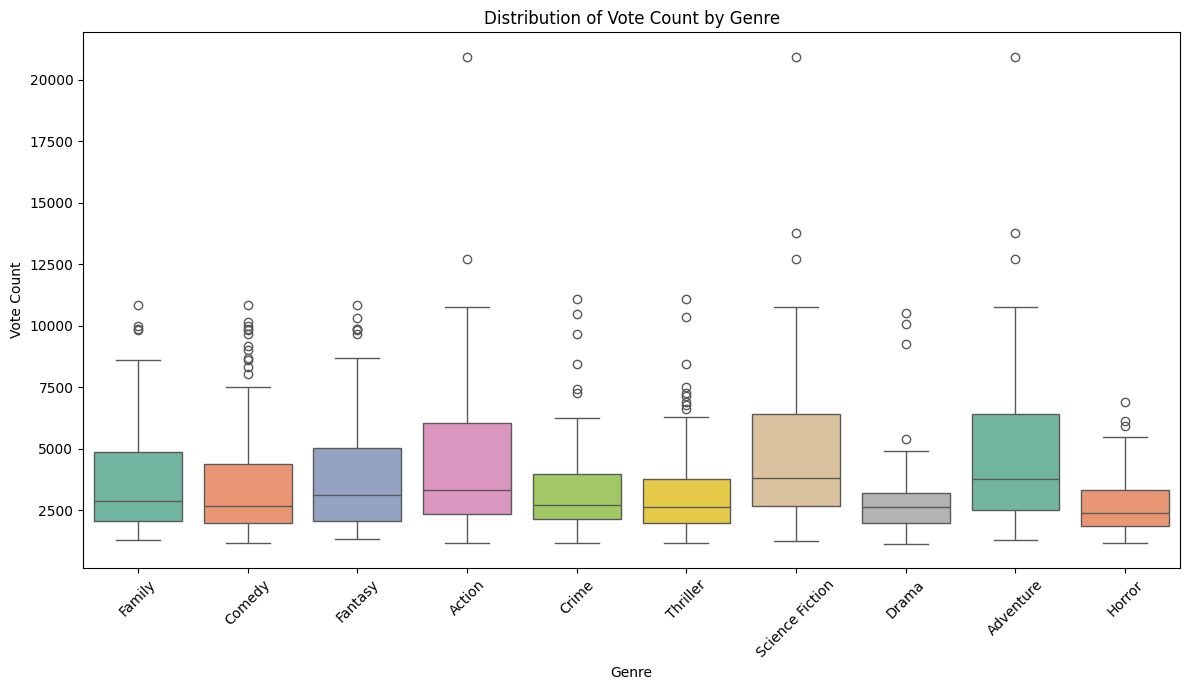

In [5]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
            x='genres', y='vote_count', palette='Set2')
# plt.yscale('log')  # Removed log scale
plt.title("Distribution of Vote Count by Genre")
plt.xlabel("Genre")
plt.ylabel("Vote Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


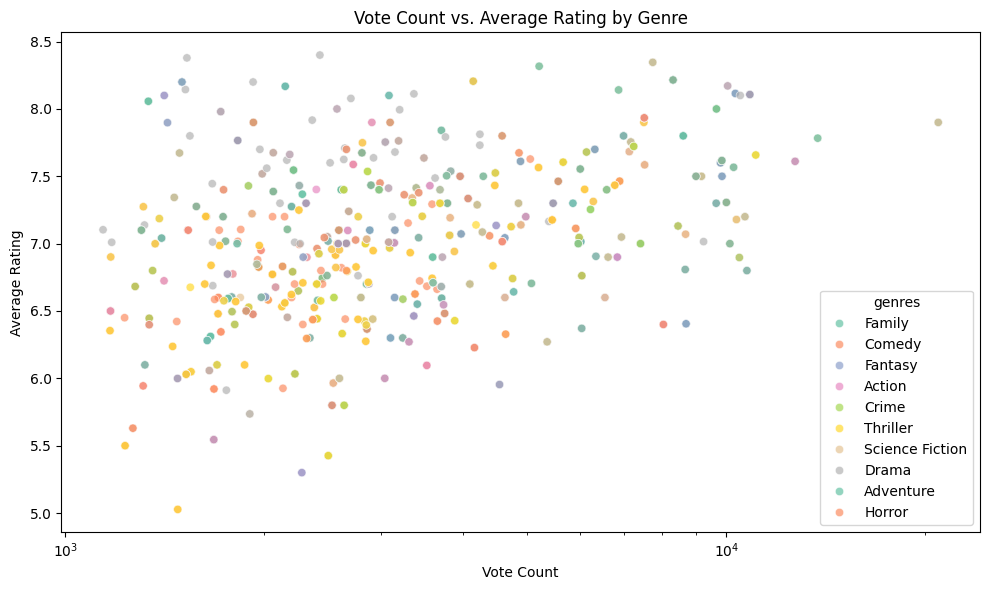

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
                x='vote_count', y='vote_average', hue='genres', palette='Set2', alpha=0.7)
plt.title('Vote Count vs. Average Rating by Genre')
plt.xlabel('Vote Count')
plt.ylabel('Average Rating')
plt.xscale('log')  # optional: because vote_count might be skewed
plt.tight_layout()
plt.show()


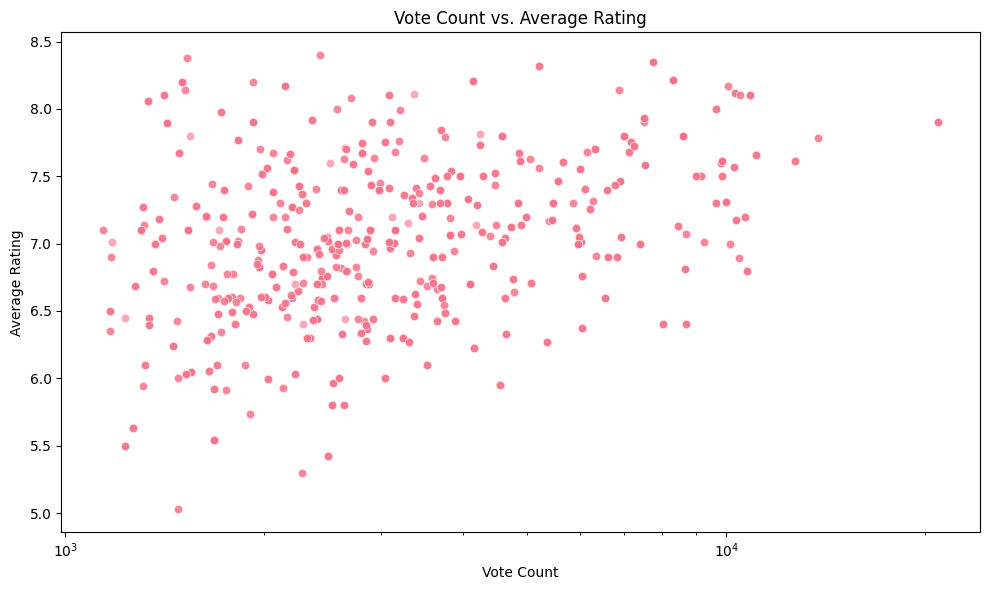

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_exploded, x='vote_count', y='vote_average', alpha=0.6)
plt.title('Vote Count vs. Average Rating')
plt.xlabel('Vote Count')
plt.ylabel('Average Rating')
plt.xscale('log')  # optional, but helpful if vote_count is skewed
plt.tight_layout()
plt.show()


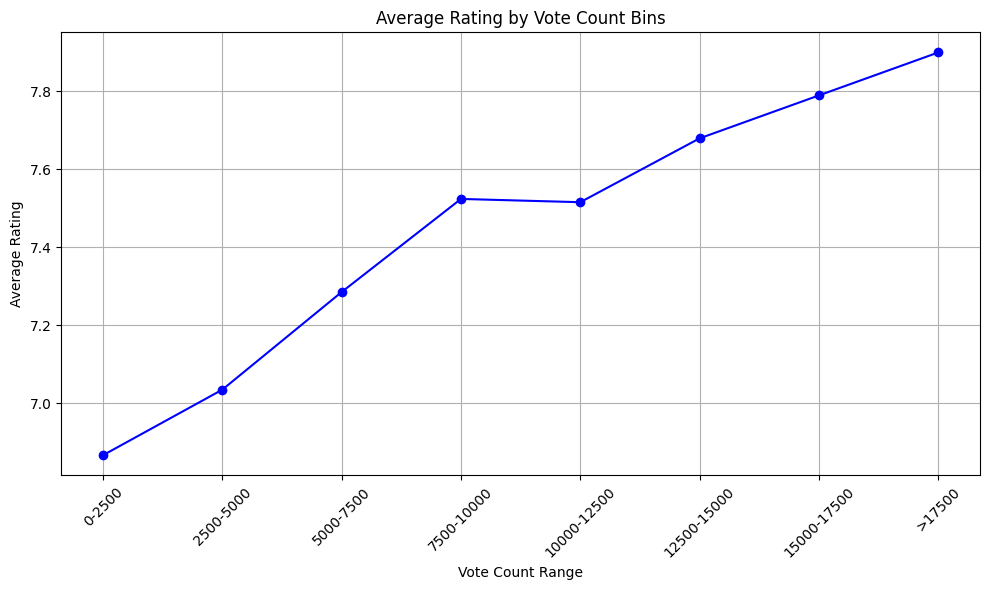

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Define explicit bins with the last bin going up to infinity
bins = [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, float('inf')]

# Create bin labels, last one as ">17500"
bin_labels = ['0-2500', '2500-5000', '5000-7500', '7500-10000',
              '10000-12500', '12500-15000', '15000-17500', '>17500']

# Bin the vote_count values
df_exploded['vote_count_bin'] = pd.cut(df_exploded['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df_exploded.groupby('vote_count_bin')['vote_average'].mean()

# Replace NaNs with interpolation or forward fill to avoid broken line (optional)
avg_rating_per_bin = avg_rating_per_bin.interpolate().fillna(method='bfill').fillna(method='ffill')

# Plot with numeric x-axis to connect all points
x = range(len(avg_rating_per_bin))
y = avg_rating_per_bin.values

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.xticks(x, avg_rating_per_bin.index, rotation=45)
plt.title('Average Rating by Vote Count Bins')
plt.xlabel('Vote Count Range')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Define lower and higher bins
lower_bin = '0-2500'
higher_bin = '>17500'

# Filter movies in the lower bin, sort by rating descending, show top 5
lower_movies = df_exploded[df_exploded['vote_count_bin'] == lower_bin] \
                .sort_values('vote_average', ascending=False) \
                .head(5)

# Filter movies in the higher bin, sort by rating descending, show top 5
higher_movies = df_exploded[df_exploded['vote_count_bin'] == higher_bin] \
                 .sort_values('vote_average', ascending=False) \
                 .head(5)

print(f"Top 5 movies with low votes ({lower_bin}):")
print(lower_movies[['title', 'vote_count', 'vote_average']])

print("\nTop 5 movies with high votes (>{}):".format(higher_bin))
print(higher_movies[['title', 'vote_count', 'vote_average']])


Top 5 movies with low votes (0-2500):
                                 title  vote_count  vote_average
45                   Gabriel's Inferno        2427         8.400
45                   Gabriel's Inferno        2427         8.400
67          Gabriel's Inferno: Part II        1527         8.379
67          Gabriel's Inferno: Part II        1527         8.379
69  Justice League Dark: Apokolips War        1501         8.200

Top 5 movies with high votes (>>17500):
                      title  vote_count  vote_average
75  Spider-Man: No Way Home       20937           7.9
75  Spider-Man: No Way Home       20937           7.9
75  Spider-Man: No Way Home       20937           7.9


In [22]:
lower_movies = df_exploded[df_exploded['vote_count_bin'] == lower_bin].drop_duplicates(subset=['title'])
higher_movies = df_exploded[df_exploded['vote_count_bin'] == higher_bin].drop_duplicates(subset=['title'])
print("Average rating per bin:")
print(avg_rating_per_bin)

print("\nMedian rating per bin:")
print(df_exploded.groupby('vote_count_bin')['vote_average'].median())


Average rating per bin:
vote_count_bin
0-2500         6.867278
2500-5000      7.035367
5000-7500      7.285705
7500-10000     7.524397
10000-12500    7.516029
12500-15000    7.679800
15000-17500    7.789900
>17500         7.900000
Name: vote_average, dtype: float64

Median rating per bin:
vote_count_bin
0-2500         6.8260
2500-5000      7.0440
5000-7500      7.3000
7500-10000     7.6000
10000-12500    7.4365
12500-15000    7.6110
15000-17500       NaN
>17500         7.9000
Name: vote_average, dtype: float64


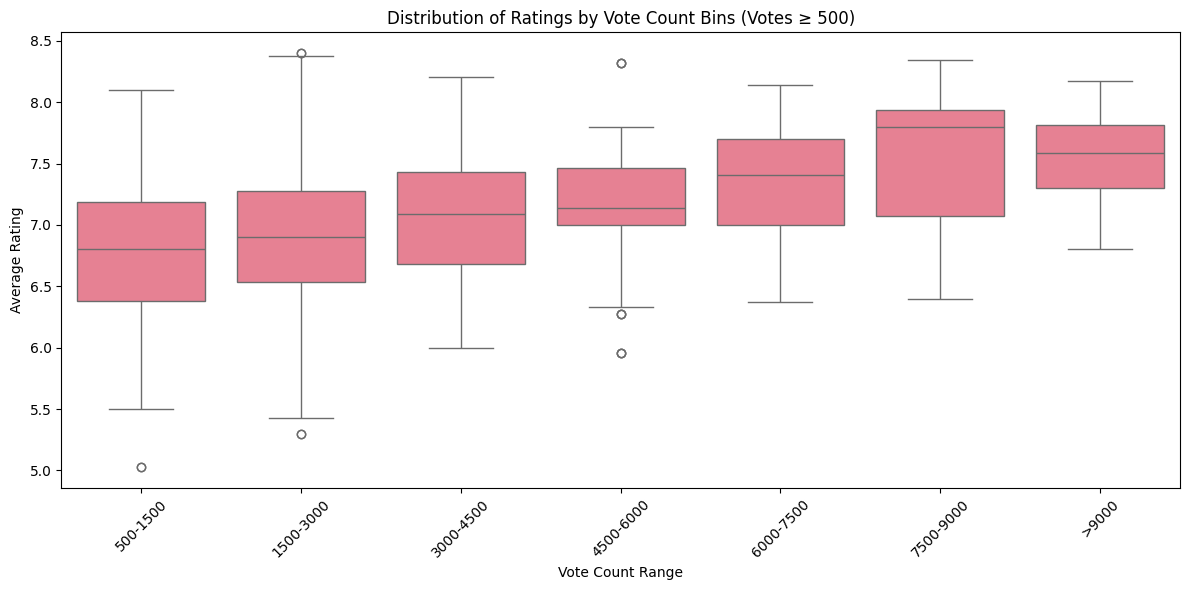

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data
df_filtered = df_exploded[df_exploded['vote_count'] >= 500].copy()

# Define bins and labels starting from 500
bins = [500, 1500, 3000, 4500, 6000, 7500, 9000, float('inf')]
bin_labels = ['500-1500', '1500-3000', '3000-4500', '4500-6000', '6000-7500', '7500-9000', '>9000']

# Bin vote counts
df_filtered['vote_count_bin'] = pd.cut(df_filtered['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Plot boxplot on filtered and binned data
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='vote_count_bin', y='vote_average')
plt.xticks(rotation=45)
plt.title('Distribution of Ratings by Vote Count Bins (Votes ≥ 500)')
plt.xlabel('Vote Count Range')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


In [24]:
counts_per_bin = df_exploded['vote_count_bin'].value_counts().sort_index()
print(counts_per_bin)


vote_count_bin
0-2500         424
2500-5000      425
5000-7500      112
7500-10000      63
10000-12500     34
12500-15000      5
15000-17500      0
>17500           3
Name: count, dtype: int64


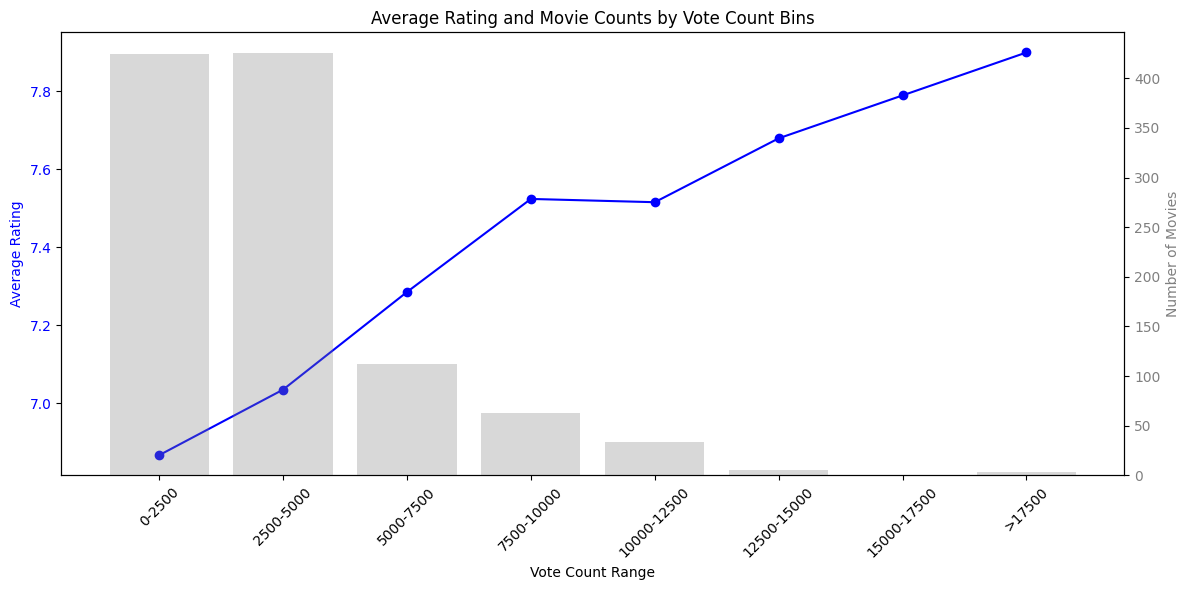

In [25]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average rating line
ax1.plot(avg_rating_per_bin.index, avg_rating_per_bin.values, marker='o', color='b', label='Average Rating')
ax1.set_xlabel('Vote Count Range')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(avg_rating_per_bin.index, rotation=45)

# Create twin axis to plot counts as bars
ax2 = ax1.twinx()
ax2.bar(counts_per_bin.index, counts_per_bin.values, alpha=0.3, color='gray', label='Movie Count')
ax2.set_ylabel('Number of Movies', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating and Movie Counts by Vote Count Bins')
fig.tight_layout()
plt.show()


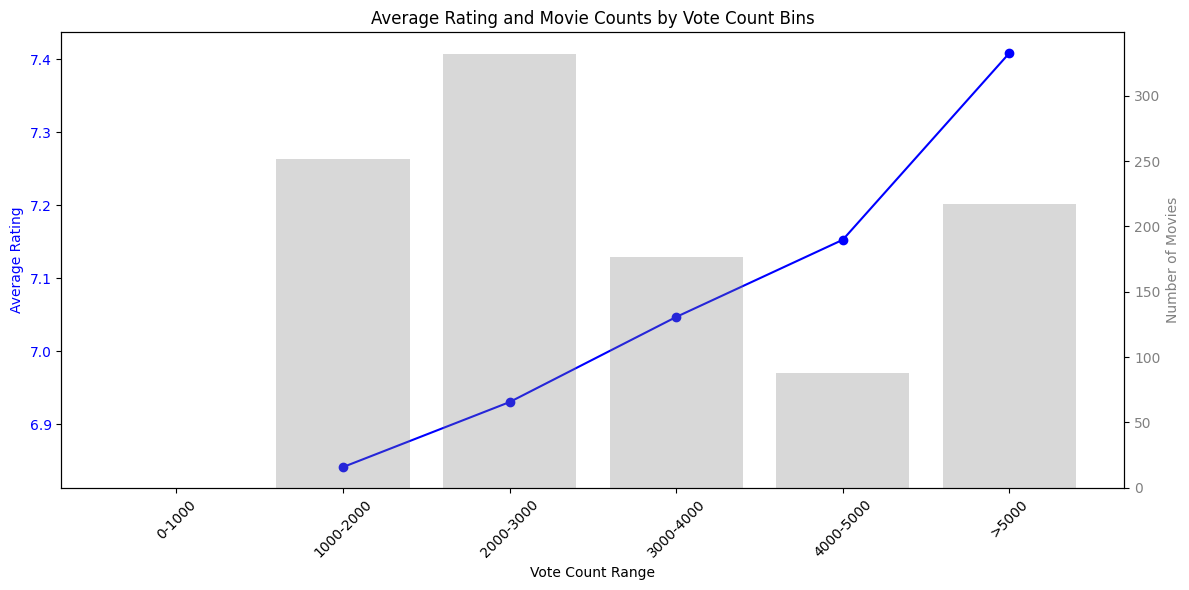

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Define new bins and labels
bins = [0, 1000, 2000, 3000, 4000, 5000, float('inf')]
bin_labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '>5000']

# Bin vote counts
df_exploded['vote_count_bin'] = pd.cut(df_exploded['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df_exploded.groupby('vote_count_bin')['vote_average'].mean()

# Calculate movie counts per bin
counts_per_bin = df_exploded['vote_count_bin'].value_counts().reindex(bin_labels)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for average rating
x = range(len(bin_labels))
ax1.plot(x, avg_rating_per_bin.values, marker='o', color='b', label='Average Rating')
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_xlabel('Vote Count Range')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Twin axis for counts bar plot
ax2 = ax1.twinx()
ax2.bar(x, counts_per_bin.values, alpha=0.3, color='gray', label='Movie Count')
ax2.set_ylabel('Number of Movies', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating and Movie Counts by Vote Count Bins')
plt.tight_layout()
plt.show()


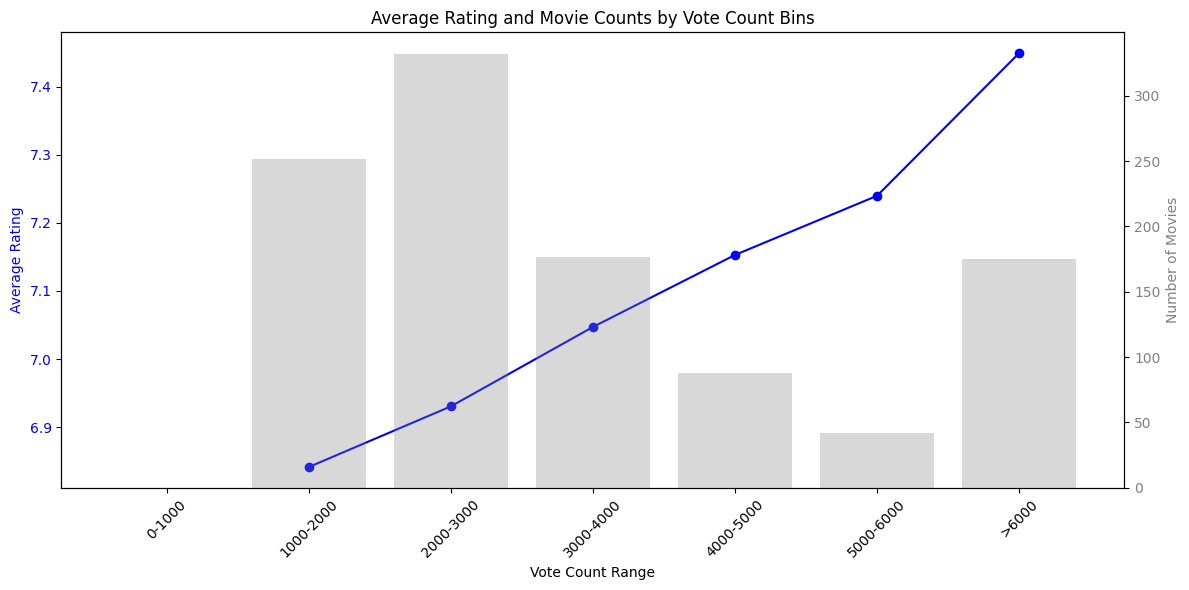

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Define new bins and labels
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, float('inf')]
bin_labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '>6000']

# Bin vote counts
df_exploded['vote_count_bin'] = pd.cut(df_exploded['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df_exploded.groupby('vote_count_bin')['vote_average'].mean()

# Calculate movie counts per bin
counts_per_bin = df_exploded['vote_count_bin'].value_counts().reindex(bin_labels)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for average rating
x = range(len(bin_labels))
ax1.plot(x, avg_rating_per_bin.values, marker='o', color='b', label='Average Rating')
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_xlabel('Vote Count Range')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Twin axis for counts bar plot
ax2 = ax1.twinx()
ax2.bar(x, counts_per_bin.values, alpha=0.3, color='gray', label='Movie Count')
ax2.set_ylabel('Number of Movies', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating and Movie Counts by Vote Count Bins')
plt.tight_layout()
plt.show()


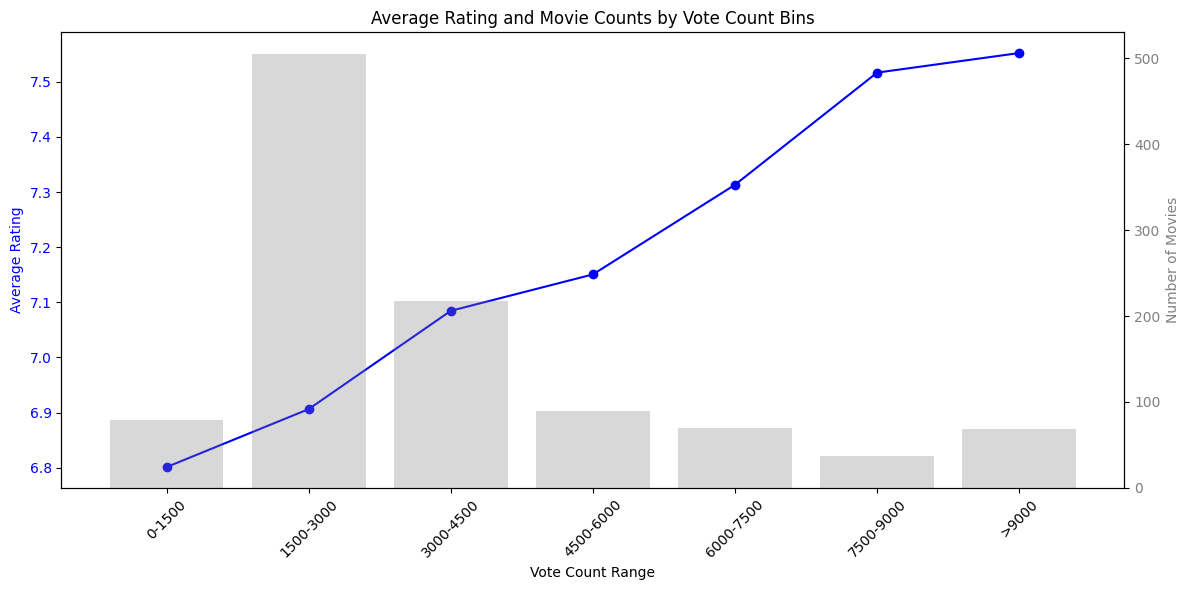

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Define bins and labels
bins = [0, 1500, 3000, 4500, 6000, 7500, 9000, float('inf')]
bin_labels = ['0-1500', '1500-3000', '3000-4500', '4500-6000', '6000-7500', '7500-9000', '>9000']

# Bin vote counts
df_exploded['vote_count_bin'] = pd.cut(df_exploded['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df_exploded.groupby('vote_count_bin')['vote_average'].mean()

# Calculate counts per bin
counts_per_bin = df_exploded['vote_count_bin'].value_counts().reindex(bin_labels)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(bin_labels))

# Plot average rating line
ax1.plot(x, avg_rating_per_bin.values, marker='o', color='b', label='Average Rating')
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_xlabel('Vote Count Range')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot movie counts as bar on twin axis
ax2 = ax1.twinx()
ax2.bar(x, counts_per_bin.values, alpha=0.3, color='gray', label='Movie Count')
ax2.set_ylabel('Number of Movies', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating and Movie Counts by Vote Count Bins')
plt.tight_layout()
plt.show()


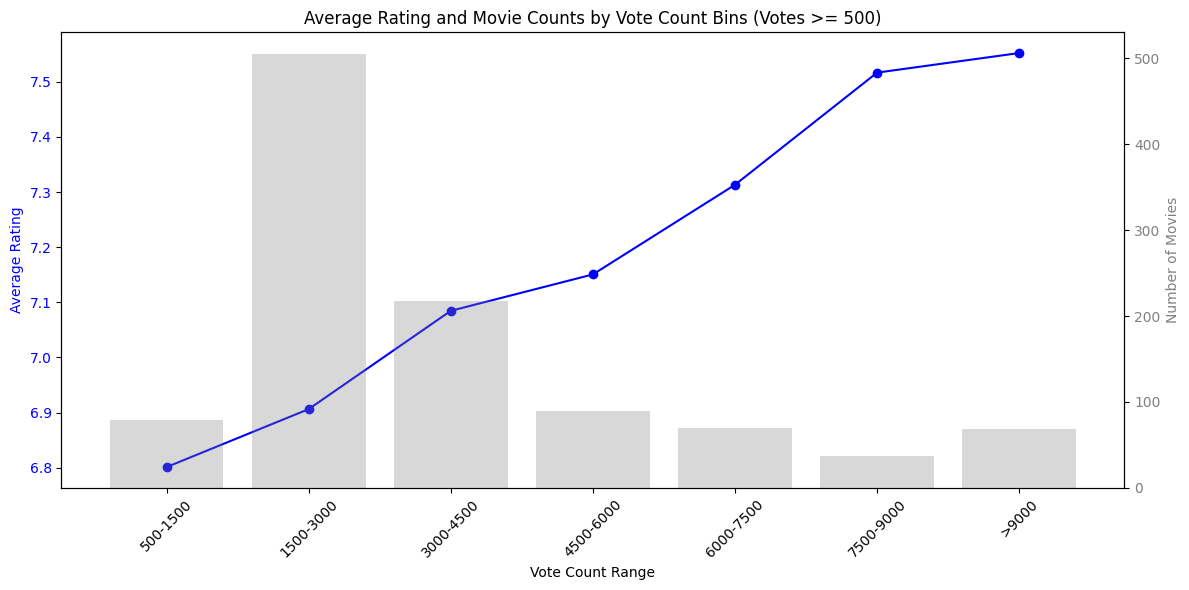

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter movies with vote_count >= 500
df_filtered = df_exploded[df_exploded['vote_count'] >= 500].copy()

# Define new bins and labels starting from 500
bins = [500, 1500, 3000, 4500, 6000, 7500, 9000, float('inf')]
bin_labels = ['500-1500', '1500-3000', '3000-4500', '4500-6000', '6000-7500', '7500-9000', '>9000']

# Bin vote counts
df_filtered['vote_count_bin'] = pd.cut(df_filtered['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df_filtered.groupby('vote_count_bin')['vote_average'].mean()

# Calculate counts per bin
counts_per_bin = df_filtered['vote_count_bin'].value_counts().reindex(bin_labels)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(bin_labels))

# Line plot for average rating
ax1.plot(x, avg_rating_per_bin.values, marker='o', color='b', label='Average Rating')
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_xlabel('Vote Count Range')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Twin axis for counts bar plot
ax2 = ax1.twinx()
ax2.bar(x, counts_per_bin.values, alpha=0.3, color='gray', label='Movie Count')
ax2.set_ylabel('Number of Movies', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating and Movie Counts by Vote Count Bins (Votes >= 500)')
plt.tight_layout()
plt.show()


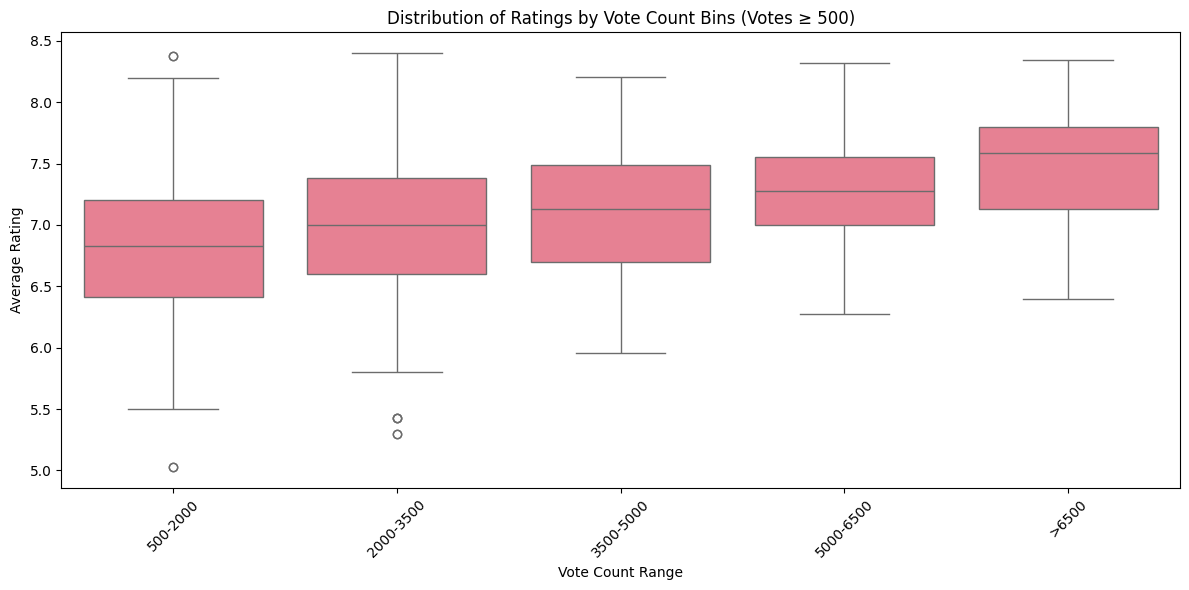

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data
df_filtered = df_exploded[df_exploded['vote_count'] >= 500].copy()

# Define new bins and labels
bins = [500, 2000, 3500, 5000, 6500, float('inf')]
bin_labels = ['500-2000', '2000-3500', '3500-5000', '5000-6500', '>6500']

# Bin vote counts
df_filtered['vote_count_bin'] = pd.cut(df_filtered['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='vote_count_bin', y='vote_average')
plt.xticks(rotation=45)
plt.title('Distribution of Ratings by Vote Count Bins (Votes ≥ 500)')
plt.xlabel('Vote Count Range')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


In [34]:
unique_movies = df_filtered[['title', 'vote_count_bin']].drop_duplicates()

#  count unique movies per bin
unique_counts_per_bin = unique_movies['vote_count_bin'].value_counts().reindex(bin_labels).fillna(0)

print("Unique movies per bin:")
print(unique_counts_per_bin)


Unique movies per bin:
vote_count_bin
500-2000      94
2000-3500    153
3500-5000     57
5000-6500     24
>6500         47
Name: count, dtype: int64


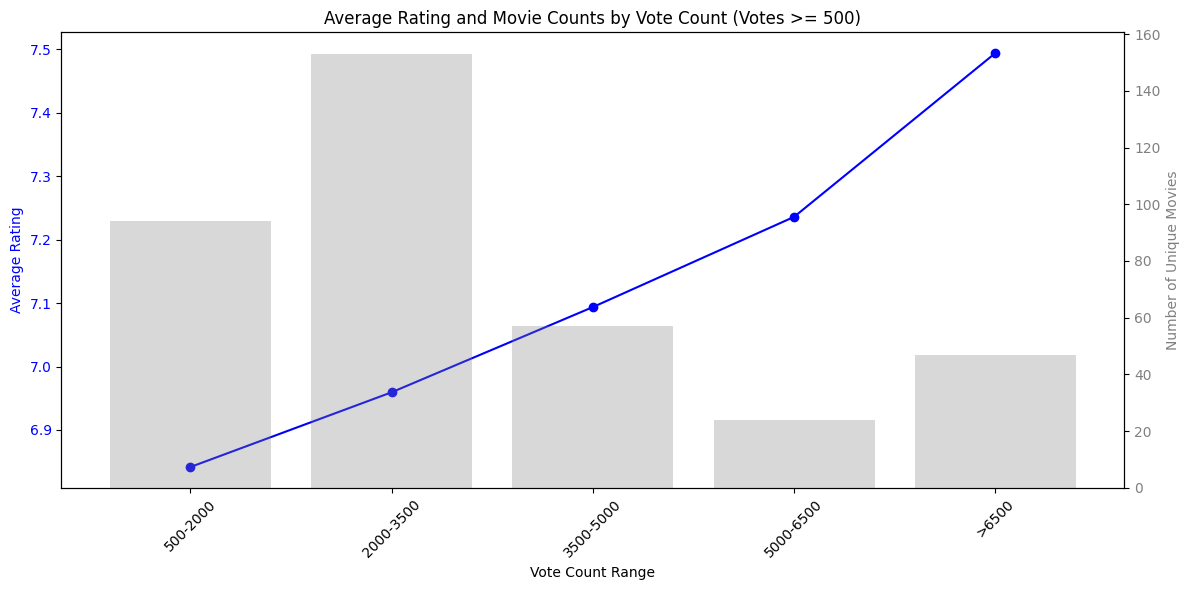

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter movies with vote_count >= 500
df_filtered = df_exploded[df_exploded['vote_count'] >= 500].copy()

# Define bins and labels
bins = [500, 2000, 3500, 5000, 6500, float('inf')]
bin_labels = ['500-2000', '2000-3500', '3500-5000', '5000-6500', '>6500']

# Bin vote counts
df_filtered['vote_count_bin'] = pd.cut(df_filtered['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df_filtered.groupby('vote_count_bin')['vote_average'].mean()

# Count unique movies per bin using 'title' as unique ID (replace with your unique id if needed)
unique_movies = df_filtered[['title', 'vote_count_bin']].drop_duplicates()
unique_counts_per_bin = unique_movies['vote_count_bin'].value_counts().reindex(bin_labels).fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(bin_labels))

# Line plot for average rating
ax1.plot(x, avg_rating_per_bin.values, marker='o', color='b', label='Average Rating')
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_xlabel('Vote Count Range')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Twin axis for unique movie counts bar plot
ax2 = ax1.twinx()
ax2.bar(x, unique_counts_per_bin.values, alpha=0.3, color='gray', label=' Movie Count')
ax2.set_ylabel('Number of Unique Movies', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating and Movie Counts by Vote Count (Votes >= 500)')
plt.tight_layout()
plt.show()
